## 1. 네이버 주식 종목 예측하기

### STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/naver.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [2]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

우리는 종가(Close)만 사용하겠습니다.

In [4]:
ts = df['Close']

ts.head()

Date
2021-05-03    363000.0
2021-05-04    364500.0
2021-05-06    361500.0
2021-05-07    361000.0
2021-05-10    362000.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

결측치 처리와 로그 변환을 해줄 것이다. 로그 변환

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

이 데이터에는 결측치가 없다. 

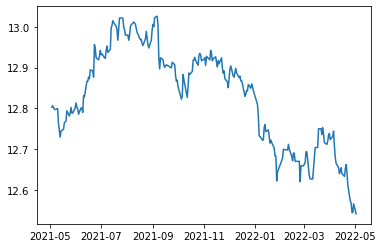

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

In [7]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.208394
p-value                          0.937514
#Lags Used                       2.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


In [8]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.022963
p-value                          0.960390
#Lags Used                       2.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


그래프가 안정적이지 않아서 그런지 로그를 취해도 p-value 가 떨어지지 않는다. 

### STEP 3 : 시계열 안정성 분석


* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

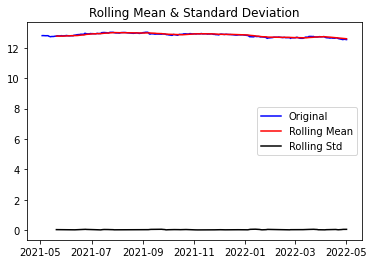

Results of Dickey-Fuller Test:
Test Statistic                   0.022963
p-value                          0.960390
#Lags Used                       2.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


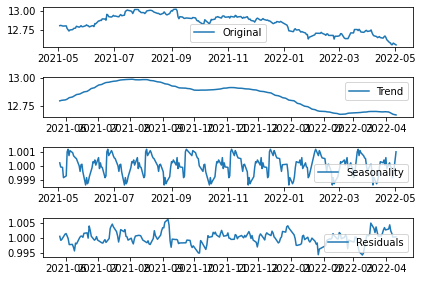

In [9]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.506525
p-value                          0.000002
#Lags Used                       3.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


Decomposing을 통해 얻어진 Residual은 0.000002로 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다

### STEP 4 : 학습, 테스트 데이터셋 생성

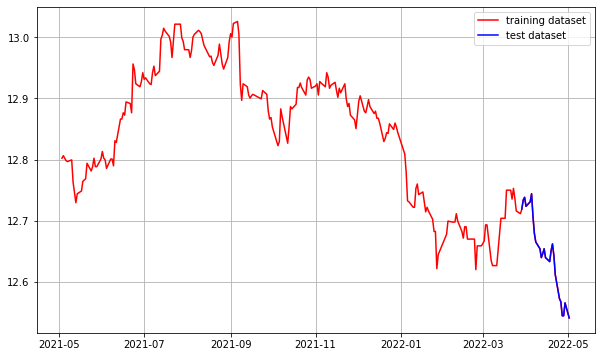

In [11]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


In [12]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

#데이터 셋의 형태 확인해주기

Date
2021-05-03    12.802158
2021-05-04    12.806282
Name: Close, dtype: float64
(221,)
(25,)


### STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기<br>
* 차분 안정성 확인 -> d 구하기

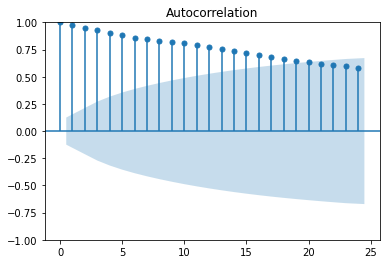

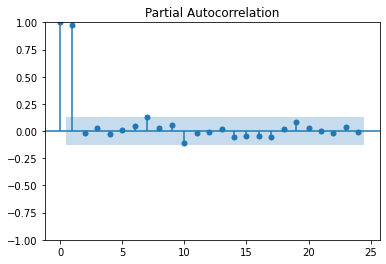

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
### 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.221090e+01
p-value                        1.164479e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


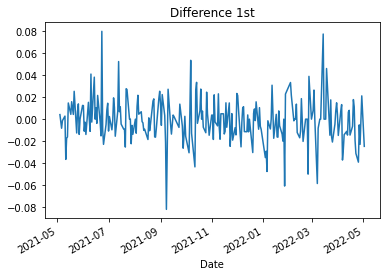

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                -7.716406e+00
p-value                        1.224950e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


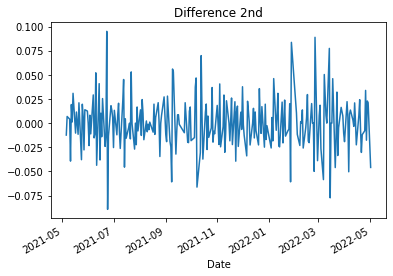

In [15]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 1차 차분의 p-value 값이 2차 차분 값보다 더 낮게 나왔다. 따라서 최적의 차분은 d=1 이다. 


### STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련<br>
모델 테스트 및 플로팅<br>
최종 예측 모델 정확도 측정(MAPE)

In [16]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 549.721
Date:                Tue, 03 May 2022   AIC                          -1095.442
Time:                        05:28:03   BIC                          -1088.655
Sample:                             0   HQIC                         -1092.701
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0546      0.073      0.748      0.454      -0.089       0.198
sigma2         0.0004   2.36e-05     16.723      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


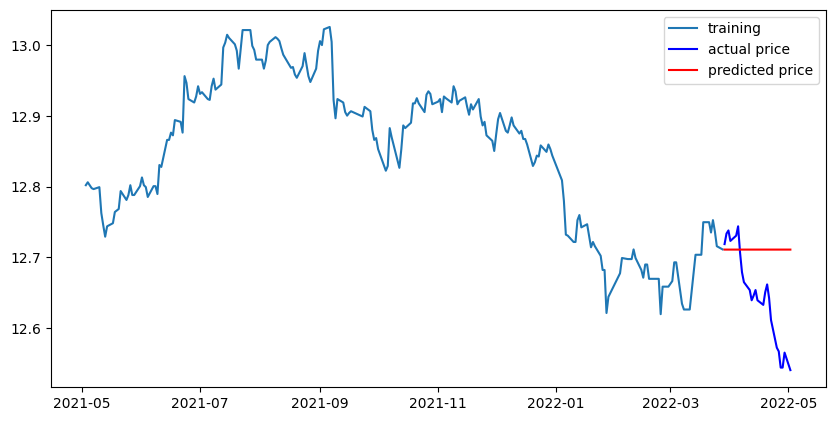

In [17]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  770269077.360329
MAE:  22834.826180190128
RMSE:  27753.72186500991
MAPE: 7.67%


# 사실 예측은 상승할 것이라 했지만 실제로는 하락했기에 mape 가 7.67 이 나와주었다. 

## 2. cj 제일제당 주식 종목 예측하기

### STEP 1 : 시계열 데이터 준비

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/cj 제일제당.csv'
df2 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df2.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [20]:
ts2 = df2['Close']

ts2.head()

Date
2021-05-03    407500.0
2021-05-04    407000.0
2021-05-06    407500.0
2021-05-07    427000.0
2021-05-10    435000.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [21]:
# 결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

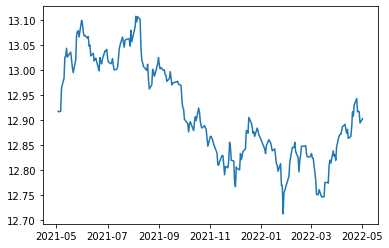

In [22]:
# 로그 변환 시도 
ts2_log = np.log(ts2)
plt.plot(ts2_log)

In [23]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -1.320737
p-value                          0.619633
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [24]:
augmented_dickey_fuller_test(ts2_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.342418
p-value                          0.609550
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


이번 값은 어느정도 규칙성이 있는지 로그를 취했더니 p-value값이 조금 줄어들었다. 

### STEP 3 : 시계열 안정성 분석


* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

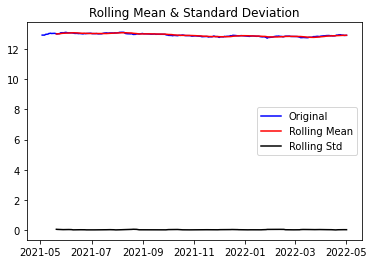

Results of Dickey-Fuller Test:
Test Statistic                  -1.342418
p-value                          0.609550
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


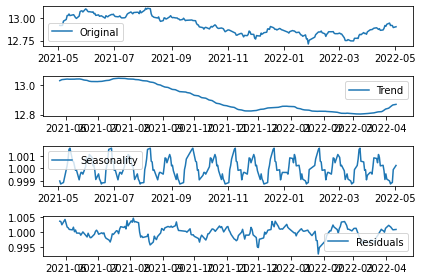

In [25]:
# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [26]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.095997e+00
p-value                        1.009773e-07
#Lags Used                     1.000000e+01
Number of Observations Used    2.050000e+02
Critical Value (1%)           -3.462658e+00
Critical Value (5%)           -2.875744e+00
Critical Value (10%)          -2.574341e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 1.009773e-07로 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다 앞서 했던 네이버 주식보다 낮군요.

### STEP 4 : 학습, 테스트 데이터셋 생성

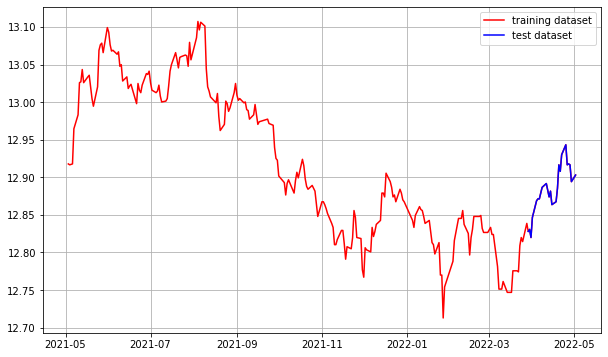

In [27]:
train_data2, test_data2 = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()


### STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기<br>
* 차분 안정성 확인 -> d 구하기

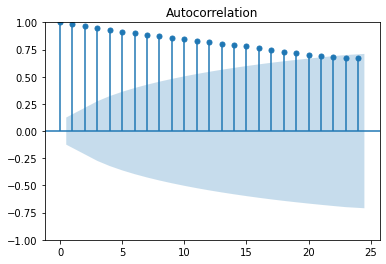

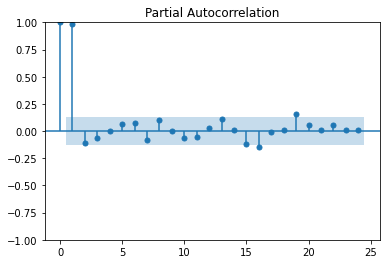

In [28]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
### 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.452631e+01
p-value                        5.421384e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


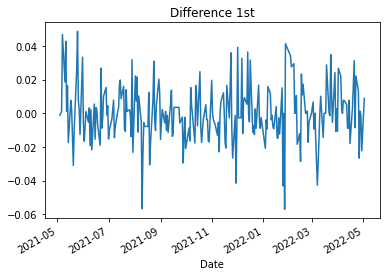

In [29]:
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                -7.758886e+00
p-value                        9.572427e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


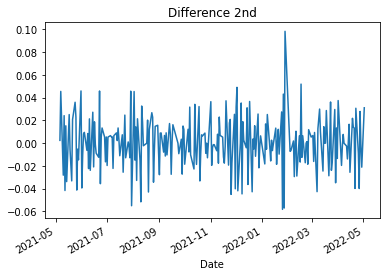

In [30]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 1차 차분의 p-value 값이 2차 차분 값보다 더 낮게 나왔다. 따라서 최적의 차분은 d=1 이다. 


### STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련<br>
모델 테스트 및 플로팅<br>
최종 예측 모델 정확도 측정(MAPE)

In [31]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data2, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 585.497
Date:                Tue, 03 May 2022   AIC                          -1162.995
Time:                        05:28:07   BIC                          -1149.402
Sample:                             0   HQIC                         -1157.506
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9059      0.082    157.091      0.000      12.745      13.067
ar.L1          0.9851      0.010     94.889      0.000       0.965       1.005
ma.L1          0.0727      0.063      1.152      0.2

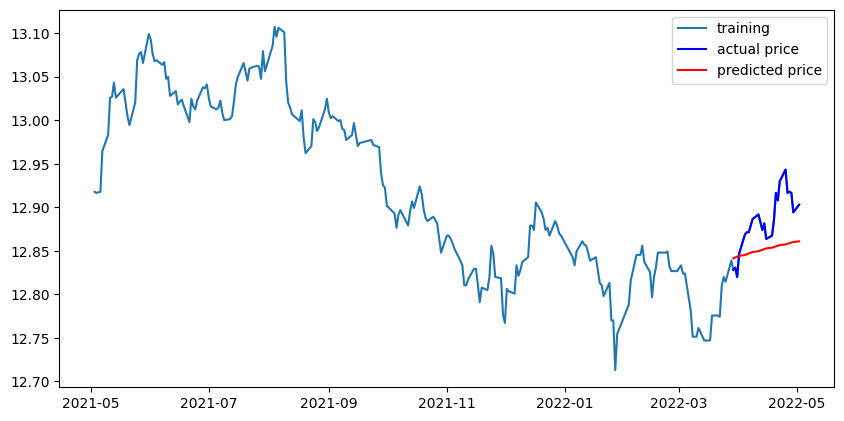

In [32]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data2), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data2.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(ts2_log, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data2), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data2), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  266441077.49363005
MAE:  14081.951056589456
RMSE:  16323.022927559407
MAPE: 3.52%


이번에는 꽤나 예측을 잘 한 것 같다. MAPE도 낮게 나왔고 예상곡선도 실제 곡선과 꽤 비슷했다.

## 3. LG 화학 주식 종목 예측하기

### STEP 1 : 시계열 데이터 준비

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/LG화학.csv'
df3 = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df3.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [35]:
ts3 = df3['Close']

ts3.head()

Date
2021-05-03    907000.0
2021-05-04    920000.0
2021-05-06    938000.0
2021-05-07    919000.0
2021-05-10    912000.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [36]:
# 결측치 처리
ts3 = ts3.interpolate(method='time')
ts3[ts3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

이 데이터에는 결측치가 없다. 

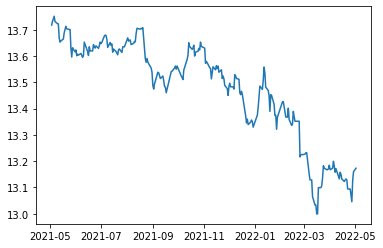

In [37]:
# 로그 변환 시도 
ts3_log = np.log(ts3)
plt.plot(ts3_log)

In [38]:
augmented_dickey_fuller_test(ts3)

Results of Dickey-Fuller Test:
Test Statistic                  -1.116995
p-value                          0.708247
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [39]:
augmented_dickey_fuller_test(ts3_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.948615
p-value                          0.771542
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


이번 값은 로그를 취해도 P-value 가 줄어들지 않았다. 이번 데이터도 네이버 처럼 시계열 데이터가 안정적이지 않다라고 생각한다.

### STEP 3 : 시계열 안정성 분석


* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

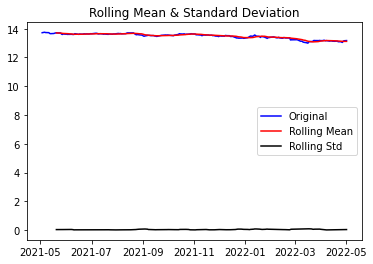

Results of Dickey-Fuller Test:
Test Statistic                  -0.948615
p-value                          0.771542
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


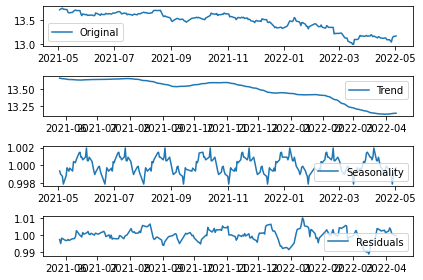

In [40]:
# 정성적 그래프 분석
plot_rolling_statistics(ts3_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts3_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [41]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.811155e+00
p-value                        4.398273e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


#### Decomposing을 통해 얻어진 Residual은  4.398273e-07로 압도적으로 낮은 p-value를 보여 줍니다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

### STEP 4 : 학습, 테스트 데이터셋 생성

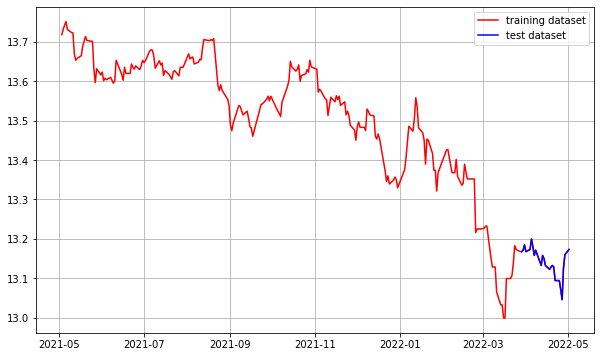

In [42]:
train_data3, test_data3 = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data3, c='b', label='test dataset')
plt.legend()


### STEP 5 : 적정 ARIMA 모수 찾기

* ACF, PACF 그려보기 -> p,q 구하기<br>
* 차분 안정성 확인 -> d 구하기

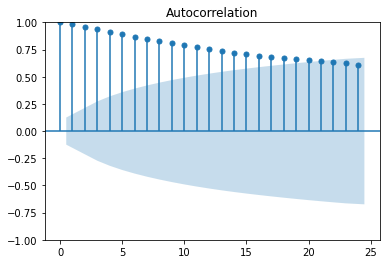

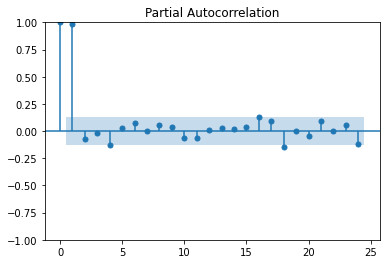

In [43]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts3_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 이 결론에 따라 보자면 PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
### 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.499548e+01
p-value                        1.109337e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


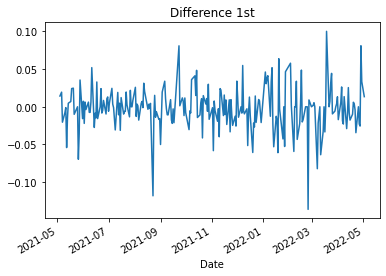

In [44]:
# 1차 차분 구하기
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                -7.795793e+00
p-value                        7.724332e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


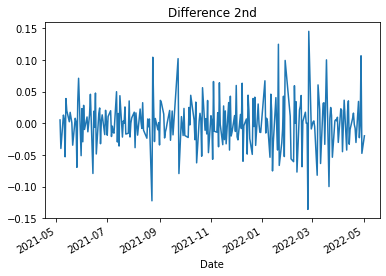

In [45]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 1차 차분의 p-value 값이 2차 차분 값보다 더 낮게 나왔다. 따라서 최적의 차분은 d=1 이다. 


### STEP 6 : ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련<br>
모델 테스트 및 플로팅<br>
최종 예측 모델 정확도 측정(MAPE)

In [46]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data3, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 470.807
Date:                Tue, 03 May 2022   AIC                           -937.615
Time:                        05:28:10   BIC                           -930.827
Sample:                             0   HQIC                          -934.874
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0410      0.084      0.489      0.625      -0.123       0.205
sigma2         0.0008   4.54e-05     17.847      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

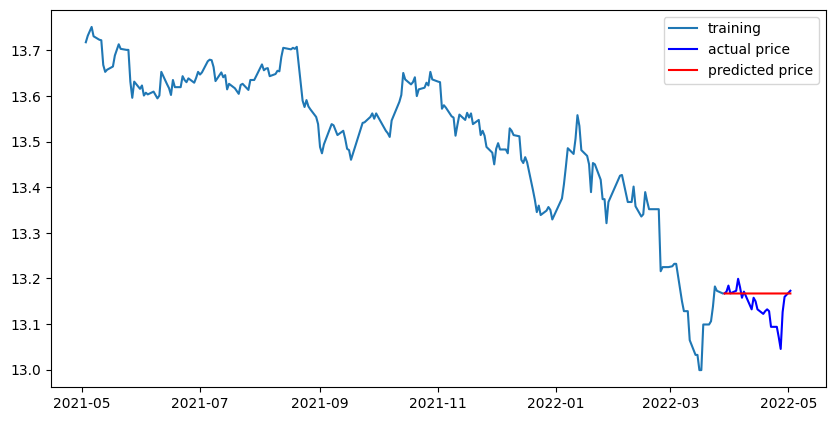

In [47]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data3), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data3.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data3), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data3), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  482614998.89219177
MAE:  15923.984722294193
RMSE:  21968.500151175358
MAPE: 3.22%


Mape가 3.22 로 적당히 작게 나왔다. 